# Knowledge Graphs Assigment 1
*Submitted by Geraldine Pang on 13th October 2019*

In [1]:
import xml.etree.ElementTree as ET 
import requests
from bs4 import BeautifulSoup
from googlesearch import search
import json
import re
import pandas as pd

# 1. Extract
## (A) Reading the XML file
To get the list of `cities`, parse with `BeautifulSoup`

In [2]:
soup = BeautifulSoup(open('city_list.xml','r'),'xml')
data = ET.parse('city_list.xml')
cities = []
for country in data.findall('CountryRegion'):
    for state in country.findall('State'):
        for city in state.findall('City'):
#             print(city.get('Name'), city.get('Code'))
            cities.append((city.get('Name'), country.get('Name')))
            
print(f'There are {len(cities)} cities.')

There are 1547 cities.


## (B) Scraping from Wikipedia

Data of the 1547 cities was scraped using the  `getInfoBoxData` function  of a `Handler` class I defined. Needed to use `threading` because of the long time it took to scrape all the cities.

Additional features:
- Searched for cities by appending City name after the wikipedia URL. Additional try statement to use the country name after the city (e.g. `"en.wikipedia.org/wiki/CityName,\_CountryName"`) if the infobox doesn't exist. 
- If there is a level 2 predicate, insert an `_` and join like: `level1predicate_level2predicate`. This also removes the bullet points in the process.

In [3]:
from threading import Thread
import time

class Handler():
    
    def __init__(self, cities, useGoogle=False):
        self.cities = cities
        self.cities_data = {}
        self.disambig_cities = []
        self.error_list =[]
        self.count = 0
        self.bulletpoints = [' • ', '• ', ' â€¢ ',' - ']
        self.useGoogle = useGoogle
   
    def getThing(self, url, name='table', class_='infobox'):
        r = requests.get(url)
        soup = BeautifulSoup(r.content, 'html.parser')
        thing = soup.find(name, class_=class_)
        return thing

    def getInfoBoxData(self, result, table):
        # This function extracts the infobox data, 
        # including parsing whether there needs to be level 2 predicate. 
        
        def extract_header_row(tr):
            outer_name, value = '', ''
            if tr.find('th'):
                outer_name = tr.find('th').text.replace(u'\xa0', u' ')
            if tr.find('td'):
                value = tr.find('td').text.replace(u'\xa0', u' ')
            return outer_name, value
        
        all_trs = table.find_all('tr')
        num_trs = len(all_trs)
        i = 0
        outer_name = ''

        while i < num_trs:
            tr = all_trs[i]
            if tr.get('class') and tr.get('class')[0] == 'mergedtoprow':
                outer_name, value = extract_header_row(tr)
                if outer_name and value:
                    result[outer_name] = value
            elif tr.get('class') and tr.get('class')[0] == 'mergedrow' and tr.find('th') and tr.find('td'):
                final_inner_header = ''
                inner_header = tr.find('th')
                inner_header_replaced = inner_header.text.replace(u'\xa0', u' ')
                inner_text = tr.find('td').text.replace(u'\xa0', u' ')
                if any(bullet in inner_header_replaced for bullet in self.bulletpoints):
                    final_inner_header = '{}_{}'.format(outer_name, inner_header_replaced)
                else:
                    outer_name = ''
                    final_inner_header = inner_header_replaced
                result[final_inner_header] = inner_text
            i += 1
    
    def getUrl(self, city):
        query = city + ' city wikipedia'
        result = next(search(query, num=1, stop=1, pause=10))
        print(result)
        return result
    
    def _getData(self, cities):
        for city, country in cities:
            print(city)
            if self.useGoogle:
                url = self.getUrl(city)
                time.sleep(1)
            else:
                url = f'https://en.wikipedia.org/wiki/{city}'
                
            table = self.getThing(url, class_=re.compile('infobox.*'))
            result = {}
            try:
                if table is None:
                    url += f',_{country}' # disambiguation using country name
                    table = self.getThing(url, class_=re.compile('infobox.*'))

                self.getInfoBoxData(result, table)

            except AttributeError as e:
                # Missing infobox 
                print('Disambiguation error: ' + city)
                self.disambig_cities.append(city)

            except Exception as e:
                print('Something else went wrong at ' + city + repr(e))
                self.error_list.append(city)
                continue

            if self.count % 100 == 0 : print(f'Status: {self.count}\n')
            self.count+=1
            if city not in self.cities_data:
                self.cities_data[city] = result
            else:
                # for cities with same name of different countries, 
                # append country name to disambiguate
                self.cities_data[city+'_'+country] = result 
        
    def chunk_cities(self, l, n=100):
        return [l[i:i + n] for i in range(0, len(l), n)]
    
    def saveData(self, fname): 
        # Save the data to a json file to avoid scraping it repeatedly.
        with open(fname+'.json','w') as f:
            json.dump(self.cities_data, f, indent=4, ensure_ascii=False)
        
    def startHandler(self, fname='scraped_data'):
        thread_list = []
        cities_chunk = self.chunk_cities(self.cities)
        
        for chunk in cities_chunk:
            t = Thread(target=self._getData, kwargs={'cities': chunk})
            t.start()
            thread_list.append(t)
            
        for t in thread_list:
            t.join()
        
        self.saveData(fname)

In [4]:
handler = Handler(cities)
handler.startHandler('scraped_data')

Herat
Uige
Sirvan
Plovdiv
Abbotsford
Wuhu
Zhanjiang
Tianmen
Xianyang
HedongHeredia

Canar
Ajaccio
GuatemalaShillong

Messina
Status: 0

Sumqayit
Zaire
Wuhan
Yan'an
Xuancheng
Kabul
Silvassa
Milano
Zhaoqing
Amiens
Disambiguation error: Hedong
Heping
Disambiguation error: Abbotsford
Barrie
ChangpingLimon

Trivandrum
Bahia Blanca
Ruse
Disambiguation error: Canar
Carchi
Xacmaz
Huehuetenango
Yulin
Zhongshan
Kandahar
Brampton
Chimborazo
ModenaIzabal

Disambiguation error: Heping
Hexi
Xiangfan
Buenos Aires
Disambiguation error: Yulin
Binzhou
Disambiguation error: Changping
Chaoyang
Disambiguation error: Xacmaz
Al-Gharbiyah
ZhuhaiUdaipur

Puntarenas
Cotopaxi
Monza e Brianza
Mazar-i Sharif
Arles
Xianning
Calgary
San Jose
Disambiguation error: Izabal
Jalapa
Dezhou
Sofiya
Naples
Disambiguation error: Hexi
Hongqiao
El Oro
Baise
Disambiguation error: Chaoyang
Chongwen
Disambiguation error: Al-Gharbiyah
Al-Hadd
Besancon
Xiantao
Catamarca
Yanam
Berat
Dongying
Daxing
Beihai
Jutiapa
Xiaogan
HezeCape Bre

Ghardaia
Choloma
Status: 500

Sudbury
Liangping
Ansbach
Disambiguation error: Cayo
Corozal
Disambiguation error: Poni
Sanguie
Disambiguation error: Dongfang
Haikou
Guelma
Sumatera Barat
Choluteca
Disambiguation error: Cuscatlan
Delgado
Arnsberg
Urumqi
Nan'an
Hanover
Lianyungang
Disambiguation error: San Nicolas
San Rafael
Sanmatenga
Disambiguation error: Putuo
Qingpu
Disambiguation error: Karlovacka
IlliziKoprivnicko-Krizevacka

Jiang Li Autonomous County
Augsburg
Sumatera Selatan
Seno
SongjiangThunder Bay
Disambiguation error: Corozal
Orange Walk

Jijel
Kingston
Colon
Nanjing
Wujiaqu
Bayreuth
Disambiguation error: Delgado
Ilopango
Disambiguation error: Koprivnicko-Krizevacka
Krapinsko-Zagorska
KhenchelaSan Luis

Sumatera Utara
Disambiguation error: Nan'an
Nanchuan
Toronto
Baoshan
Kie-Ntem
Laghouat
Berlin
Pengshui Miao-Tujia Autonomous Country
Disambiguation error: Colon
Comayagua
Disambiguation error: Songjiang
Xuhui
Manchester
Disambiguation error: Jiang Li Autonomous CountyDisambigu

Santa Cruz
Palauli
Isla de la Juventud
Bat Yam
Chaoyang
Mudanjiang
Saare
Satupaitea
Magdeburg
Sanming
Somogy
Arauca
La Habana
Yibin
Qiqihar
Quillacollo
Beersheba
Palmerston
Disambiguation error: Chaoyang
Dalian
Xiamen
Mainz
Disambiguation error: Kampong Spoe
Kampong Thum
Zigong
Santiago
Sacaba
Disambiguation error: Saare
Tartu
Haifa
Atlantico
Disambiguation error: Somogy
Szabolcs-Szatmar-Bereg
Qitaihe
Santa Cruz
Ziyang
Disambiguation error: Satupaitea
Savaii
Disambiguation error: Palmerston
Brisbane
Las Tunas
Mannheim
Zhangzhou
Dandong
Santo Antao
Status: 1000

Shuangyashan
Tolna
Valga
Changhwa County
Disambiguation error: Kampong Thum
Kampot
Disambiguation error: Atlantico
Bogota
Tuamasaga
Fushun
Holon
Suihua
Baiyin
Cairns
Muenster
Upolu
Tarija
Jerusalem
Dingxi
Vas
Yichun
Viljandi
Fuxin
Manzanillo
Sao DomingosKandal

Vaao Fonoti
Gannan Tibetan Autonomous Prefecture
Bolivar
Bosansko-Podrinjski
Huludao
Veszprem
Caloundra
Voru
Jiayuguan
Matanzas
Disambiguation error: Changhwa County
Disa

Salzburg
Region de Coquimbo
Matera
Tampere
Vaupes
Disambiguation error: Peiraievs
Rethymnis
Region de la Araucania
Styria
Paraiba
Disambiguation error: Nord
Nord-Oueste
Turku
Tyrol
Parana
Vaasa
Disambiguation error: Vaupes
Vichada
Upper Austria
Vantaa
Disambiguation error: Zlinsky
Aarhus
Disambiguation error: Rethymnis
Samos
Vienna
Aix-en-Provence
Disambiguation error: Parana
Pernambuco
Disambiguation error: Nord-Oueste
Ouest
Disambiguation error: Vichada
Alajuela
Disambiguation error: Region de la Araucania
Region de los Lagos
Bornholm
Alta Verapaz
Vorarlberg
Cartago
Piaui
Baja Verapaz
Copenhagen
Abseron
Chimaltenango
Rio de Janeiro
Disambiguation error: Ouest
Sud
Chiquimula
Frederiksborg
Guanacaste
Disambiguation error: Region de los Lagos
Region de Tarapaca
Disambiguation error: Abseron
Ganca
Rio Grande do Norte
El Progreso
Region de Valparaiso
Disambiguation error: Sud
Sud-Oueste
Kalbacar
Escuintla
Rio Grande do Sul
Region del Biobio
Lankaran
Disambiguation error: Frederiksborg
Fyn

In [5]:
len(handler.cities_data)

1547

### Missing Infoboxes
For cities which did not have their own wikipedia pages, infoboxes, or required extra disambiguation, they return an empty dict `{}`. 
- Store such cities in a `cities_empty` list and 
- rerun the querying with another instance of the `Handler` class, this time with `useGoogle=True` to perform additional searches to get the correct page on wikipedia.
- This is slower, hence we run on only the smaller set of cities separately.
- Some cities may not have wikipedia pages, and hence with this additional search still return the empty dict. We will ignore these few minority cases.

In [6]:
# cities_empty = handler.disambig_cities # for initial
cities_empty = [(city, "") for city in handler.cities_data if handler.cities_data[city]=={}] # for subsequent
print(f'{len(cities_empty)} cities may not have their own wikipages, infoboxes, or need disambiguation.')

387 cities may not have their own wikipages, infoboxes, or need disambiguation.


In [7]:
# for the cities without any info boxes, 
# use an additional google search (slower) to get the correct page
empty_handler = Handler(cities_empty, useGoogle=True) 
empty_handler.startHandler('missing_scraped_data')

Hedong
Chalatenango
VayocJor
Northern
https://en.wikipedia.org/wiki/City
https://en.wikipedia.org/wiki/Chalatenango_Department
https://en.wikipedia.org/wiki/Hedong_District,_Tianjin
https://en.wikipedia.org/wiki/List_of_northernmost_settlements
Status: 0

Ding'an
Abbotsford
Disambiguation error: VayocJor
Yunyang
Disambiguation error: Northern
Kemo
https://en.wikipedia.org/wiki/Abbotsford,_British_Columbia
https://en.wikipedia.org/wiki/Ding%27an_County
https://en.wikipedia.org/wiki/Yunyang_County
Canar
Xing'an
https://en.wikipedia.org/wiki/Quarantine_(video_game)
Chuquisaca
Enshi Tujia-Miao Autonomous Prefecture
https://en.wikipedia.org/wiki/Ca%C3%B1ar_Province
https://en.wikipedia.org/wiki/Xing%27an_Province
https://en.wikipedia.org/wiki/Chuquisaca_Department
Heping
https://en.wikipedia.org/wiki/Enshi_Tujia_and_Miao_Autonomous_Prefecture
Harju
Disambiguation error: Xing'an
Istarska
Guaviare
https://en.wikipedia.org/wiki/Heping
https://en.wikipedia.org/wiki/Harju_County
https://en.wikip

https://en.wikipedia.org/wiki/Adamawa_Region
Dongli
https://en.wikipedia.org/wiki/Savai%27i
https://en.wikipedia.org/wiki/Dehong_Dai_and_Jingpo_Autonomous_Prefecture
https://en.wikipedia.org/wiki/Formosa,_Argentina
Brisbane
Lacs
Sourou
https://en.wikipedia.org/wiki/Dongli_District
Plzensky
https://en.wikipedia.org/wiki/Brisbane
https://en.wikipedia.org/wiki/Lakh
https://en.wikipedia.org/wiki/Sourou,_Benin
Santo Antao
Medimurska
Disambiguation error: Lacs
Ash-Shamaliyah
https://en.wikipedia.org/wiki/Plze%C5%88
Bunbury
https://en.wikipedia.org/wiki/Santo_Ant%C3%A3o,_Cape_Verde
https://en.wikipedia.org/wiki/Me%C4%91imurje_County
Upolu
Cork
https://en.wikipedia.org/wiki/Al_Bunayyat_ash_Shamaliyah
Daerah Tingkat I Kalimantan Barat
https://en.wikipedia.org/wiki/Bunbury,_Western_Australia
Magallanes y Antartica Chilena
https://en.wikipedia.org/wiki/Upolu
https://en.wikipedia.org/wiki/Cork_(city)
Cairns
https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Kalimantan_Barat
El Paraiso
Disa

Java Timur
Ouest
https://en.wikipedia.org/wiki/Nanyang,_Henan
https://en.wikipedia.org/wiki/St._Mary%27s_City,_Maryland
Sao Vicente
Sisacko-Moslavacka
https://en.wikipedia.org/wiki/Montreal_West,_Quebechttps://en.wikipedia.org/wiki/East_Java

Region de los Lagos
Tungurahua
https://en.wikipedia.org/wiki/S%C3%A3o_Vicente,_S%C3%A3o_Paulo
https://en.wikipedia.org/wiki/Sisak-Moslavina_County
Mount Gambier
Xisha Qundao
https://en.wikipedia.org/wiki/Los_Lagos_Regionhttps://en.wikipedia.org/wiki/Tungurahua_Province

Alger
Abseron
https://en.wikipedia.org/wiki/Mount_Gambier,_South_Australia
https://en.wikipedia.org/wiki/Paracel_Islands
Binshangul Gumuz
Kouffo
https://en.wikipedia.org/wiki/Algiers
https://en.wikipedia.org/wiki/Absheron_District
Sud
Brabant-Wallone
https://en.wikipedia.org/wiki/Benishangul-Gumuz_Region
https://en.wikipedia.org/wiki/Toviklin
Cauca
Zhongsha Qundao
https://en.wikipedia.org/wiki/Shopping_City_S%C3%BCd
https://en.wikipedia.org/wiki/Walloon_Brabant
Frederiksborg
Chongm

In [8]:
print(f'''
Out of {len(empty_handler.cities_data)} cities successfully rerun,
there are still {len([city for city in empty_handler.cities_data if empty_handler.cities_data[city]=={}])} cities without infoboxes which we will ignore.
''')


Out of 387 cities successfully rerun,
there are still 105 cities without infoboxes which we will ignore.



In [23]:
cities_data = handler.cities_data
cities_data2 = empty_handler.cities_data 

print(f'''
Now we update the {len(cities_data2)} cities of the second run to the original set of {len(cities_data)} cities.
''')


Now we update the 387 cities of the second run to the original set of 1547 cities.



In [22]:
cities_data.update(cities_data2)
print(len(cities_data))

#Joining the two sets
# cities_data = json.load(open('scraped_data.json','r'), encoding='utf-8-sig')

1547


# 2. Transform
## (A) Cleaning the Data
Steps taken here: 
- Drop empty cities/values. 
- Remove unmeaningful characters using regex (bullet points, references)
- Remove "Websites" predicates for those that do not actually provide a link to anything. 

Future works: *(not done because not specified in requirements)*
- combine predicates which are similar e.g. Area (2011) and Area (2014 census)
- Split the level1_level2predicate into level1/level2 predicates

In [24]:
# Removing cities which still don't have infoboxes ; 
cities_noempty = [city for city in cities_data if cities_data[city]!={}]

In [25]:
regex_string = r'\[[0-9]{1,}\]|\\n|.mw-parser-output[ |_].nobold{font-weight:normal}'
bulletpoints = [' • ', '• ', ' â€¢ ',' - ']

def isempty(string):
    return string == '' or string == ' '

def clean_city(city):
    # separated for loops because of the del statement 
    
    for k in list(city.keys()):
        # Remove empty sections 
        if isempty(k):
            del city[k]
        elif isempty(city[k]):
            del city[k]
    
    for k, v in list(city.items()):
        # Regex to remove References or newline characters
        if re.search(regex_string, city[k]):
            city[k] = re.sub(regex_string, '', v)
            
        if re.search(regex_string, k):
            new_key = re.sub(regex_string, '', k)
            city[new_key] = v
            del city[k]
    
    for k in list(city.keys()):
        # Remove weird bullet points
        for bullet in bulletpoints:
            if bullet in k:
                city[k.replace(bullet, '')] = city[k]
                del city[k]
                break                
                
    # Remove non-Website entries
    if 'Website' in city:
        if city['Website'] != re.compile('.\..'):
            del city['Website']
    return city

# for city in cities_noempty:
for city in cities_data:
    clean_city(cities_data[city])
print('Done')    

Done


Bit of further cleaning for some special cases, e.g. for [Bhopal](https://en.wikipedia.org/wiki/Bhopal): When there are still some newline characters that weren't previously removed. There are two links for a single predicate, bs4 pulls it out as two lines. 

In [26]:
for city, values in cities_data.items():
    for val in values:
        if '\n' in val: #.find('\n'):
            new_val = val.replace('\n',' ')
            cities_data[city][new_val] = cities_data[city][val]
            del cities_data[city][val]

## (B) Converting into triples

In [28]:
data_triples = []

for subj in cities_data:
    for pred in cities_data[subj]:
        obj = cities_data[subj][pred]
        data_triples.append((subj, pred, obj))

In [29]:
data_triples[:10]

[('Sirvan', 'Country', 'Turkey'),
 ('Sirvan', 'Province', 'Siirt'),
 ('Sirvan', 'Post code', '56760'),
 ('Sirvan', 'Government_Mayor', 'Necat Cellek (AKP)'),
 ('Sirvan', 'Government_Kaymakam', 'Mustafa Can'),
 ('Sirvan', 'Area_District', '960.01 km2 (370.66 sq mi)'),
 ('Sirvan', 'Population (2012)_Urban', '4,451'),
 ('Sirvan', 'Population (2012)_District', '23,868'),
 ('Sirvan', 'Population (2012)_District density', '25/km2 (64/sq mi)'),
 ('Uige', 'Country', ' Angola')]

## (C) Convert to .nt File
Using the `rdflib` library, we will create URI namespaces for the triples and serialize as an `.nt` file. 

In [30]:
from rdflib import Graph, Literal, BNode, Namespace, URIRef
# from rdflib.namespace import FOAF, RDF

In [34]:
class CityGraph():

    def __init__(self):
        self.g = Graph()
        self.data = data
        self.subj_namespace = Namespace("http://example.org/city/")
        self.prop_namespace = Namespace("http://example.org/property/")

    def addTriples(self, triples):
        # Add triples to the graph while converting spaces into underscores
        for sub, pred, obj in triples:
            sub_ = self.subj_namespace[re.sub('[ ,"]', '_', sub)] # sub.replace(' ', '_')
            pred_ = self.prop_namespace[re.sub('[ ,"]', '_', pred)] #pred.replace(' ','_')]
            obj_ = Literal(obj.strip())
            self.g.add( (sub_, pred_, obj_))
    
    def generateGraph(self, destPath='output', format_='nt'):
        # Serializes the graph and saves it as .nt file
        self.g.serialize(destination=f'{destPath}.{format_}', format=format_)
        return 

g = CityGraph()
g.addTriples(data_triples)
g.generateGraph()

# 3. Load
## Upload and Query on Apache Jena

In [ ]:
!docker run -p 3030:3030 stain/jena-fuseki 
# sign in with user admin=#PASSWORD#

Expected Result:
```xml
  <CountryRegion Name="Afghanistan" Code="AFG">
    <State >
      <City Name="Herat" Code="HEA"/>
      <City Name="Kabul" Code="KBL"/>
      <City Name="Kandahar" Code="KDH"/>
      <City Name="Mazar-i Sharif" Code="MZR"/>
```

SPAQL Query:
```SPARQL
    #PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    prefix cities:<http://example.org/city/>
    prefix property:<http://example.org/property/>

    SELECT ?subject 
    WHERE {
        ?subject property:Country "Afghanistan"
    }
```
Result:
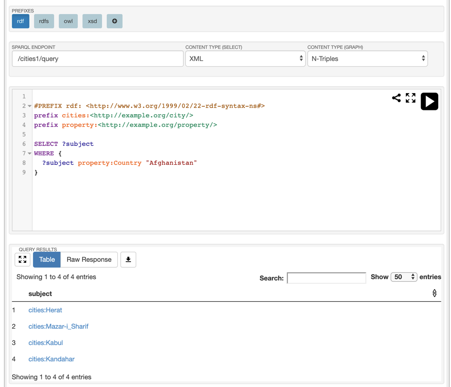